# Full prediction pipeline using YOLOv3 and Google Vision API

In [1]:
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.insert(0, "../scripts")
from prediction_utils import *
import unidecode

In [2]:
# add Cloud Vision API key to environment
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../ServiceAccountToken_VisionAPI.json'

# Get cereal info from DB
s = 'select * from cereals2'
df = pd.read_sql(s, connect_to_db())

# set allergies. options include: peanut, tree_nut, soy, wheat, coconut, egg, sesame, milk
allergies = ['peanut', 'tree_nut']

In [3]:
src_path = os.path.join('..', 'YOLOv3', 'TrainYourOwnYOLO', "2_Training", "src")
utils_path = os.path.join('..', 'YOLOv3', 'TrainYourOwnYOLO', "Utils")

sys.path.append(src_path)
sys.path.append(utils_path)

# more imports here
from keras_yolo3.yolo import YOLO
from utils import detect_object

# Set up folder names for default values
data_folder = os.path.join('..','YOLOv3','TrainYourOwnYOLO', "Data")
image_folder = os.path.join(data_folder, "Source_Images")
image_test_folder = os.path.join(image_folder, "Test_Images")
model_folder = os.path.join(data_folder, "Model_Weights")
model_weights = os.path.join(model_folder, "trained_weights_final_ck2000.h5")
model_classes = os.path.join(model_folder, "data_classes.txt")
anchors_path = os.path.join(src_path, "keras_yolo3", "model_data", "yolo_anchors.txt")

# define YOLO detector
yolo = YOLO(
    **{
        "model_path": model_weights,
        "anchors_path": anchors_path,
        "classes_path": model_classes,
        "score": 0.25,
        "gpu_num": 1,
        "model_image_size": (416, 416),
    }
)

Using TensorFlow backend.
W0618 05:04:00.233883 140680154842880 module_wrapper.py:139] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0618 05:04:00.234775 140680154842880 module_wrapper.py:139] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0618 05:04:00.235319 140680154842880 module_wrapper.py:139] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0618 05:04:00.251068 140680154842880 module_wrapper.py:139] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/keras/ba

../YOLOv3/TrainYourOwnYOLO/Data/Model_Weights/trained_weights_final_ck2000.h5 model, anchors, and classes loaded in 9.99sec.


In [4]:
# Load image
#img_fname = os.path.join('..', 'data', 'real_box_shelves', 'Walgreens-cereal-4.jpg')
img_fname = os.path.join('..', 'data', 'real_box_shelves', 'IMG_20200612_114503.jpg')

img = Image.open(img_fname).convert("RGB")
new_img = copy.deepcopy(img)

# Run YOLO detector
YOLO_predictions, new_image = yolo.detect_image(new_img);

# Only permit bounding boxes with height > width and height / width > 2.5
YOLO_predictions = [box for box in YOLO_predictions if box[3]-box[1] > box[2]-box[0] and (box[3]-box[1]) / (box[2]-box[0]) < 2.5]

# Remove bounding boxes smaller than mean_box_area - coefficient*std_box_area
areas = [(box[2]-box[0])*(box[3]-box[1]) for box in YOLO_predictions]
YOLO_predictions = [box for box, area in zip(YOLO_predictions, areas) if area > (np.mean(areas)-1.5*np.std(areas))]

# Generate vertically-stacked image 
stacked_image, stacked_img_edges = generate_stacked_image(YOLO_predictions, img)

# Detect text with Cloud Vision API and parse results
OCR_words_all, OCR_vertices = Vision_API_OCR(stacked_image)

(416, 416, 3)
Found 13 boxes for img
cereal_box 0.99 (1450, 1710) (1992, 2528)
cereal_box 0.99 (903, 1684) (1444, 2551)
cereal_box 1.00 (617, 532) (1232, 1394)
cereal_box 1.00 (2885, 637) (3442, 1471)
cereal_box 1.00 (3186, 1736) (3739, 2571)
cereal_box 1.00 (26, 518) (615, 1414)
cereal_box 1.00 (1722, 615) (2283, 1436)
cereal_box 1.00 (3758, 1733) (4032, 2615)
cereal_box 1.00 (2310, 630) (2863, 1473)
cereal_box 1.00 (2602, 1702) (3154, 2577)
cereal_box 1.00 (2016, 1691) (2566, 2594)
cereal_box 1.00 (3454, 646) (4009, 1469)
cereal_box 1.00 (1223, 711) (1712, 1473)
Time spent: 1.582sec


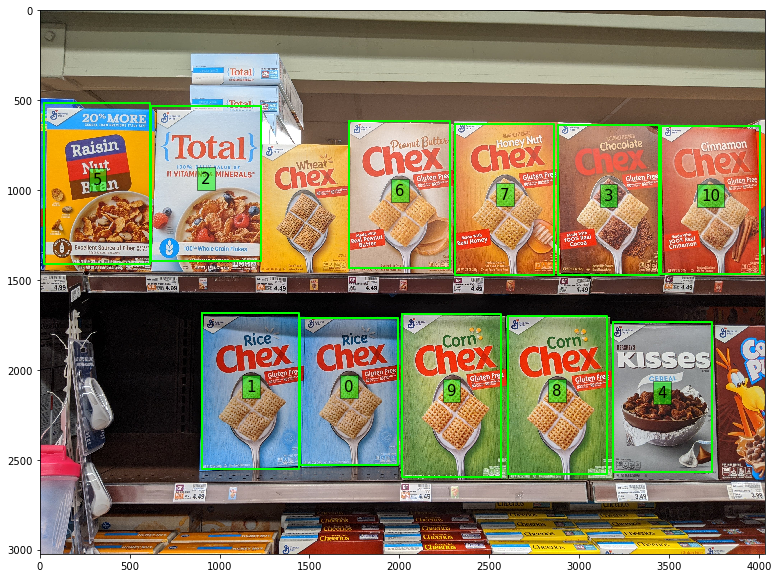

In [5]:
fig, ax = plt.subplots(1, figsize=(13,10))
ax.imshow(img);
for ix, box in enumerate(YOLO_predictions):
    ax.plot([box[0],box[2], box[2],box[0],box[0]], [box[1],box[1],box[3],box[3],box[1]], linewidth=2, color='lime')
    ax.text(np.mean([box[0], box[2]]), np.mean([box[1],box[3]]), str(ix), fontsize=15, bbox=dict(facecolor='lime', alpha=0.5), horizontalalignment='center')

In [8]:
# loop through detected boxes
prediction_results = []
for ix, box in enumerate(YOLO_predictions):
    # Find OCR text in this cereal box
    OCR_words = []
    OCR_areas = np.empty((0))
    for word, vertices in zip(OCR_words_all, OCR_vertices):
        if (vertices['y'] > stacked_img_edges[ix]).all() & (vertices['y'] < stacked_img_edges[ix+1]).all():
            word = unidecode.unidecode(word)
            OCR_words.append(process_string_for_comparison(word))
            OCR_areas = np.append(OCR_areas, PolygonArea(vertices['x'], vertices['y']))
    
    # strip any whitespace
    OCR_words = list(map(str.strip, OCR_words))
    
    if len(OCR_words) > 0:
        # predict cereal
        label, confidence = get_cereal(df, OCR_words, OCR_areas)
        # compile results in dictionary
        prediction_results.append({
            'OCR_words': OCR_words,
            'OCR_areas': OCR_areas,
            'box': box[0:4],
            'label': label,
            'confidence': confidence
        })

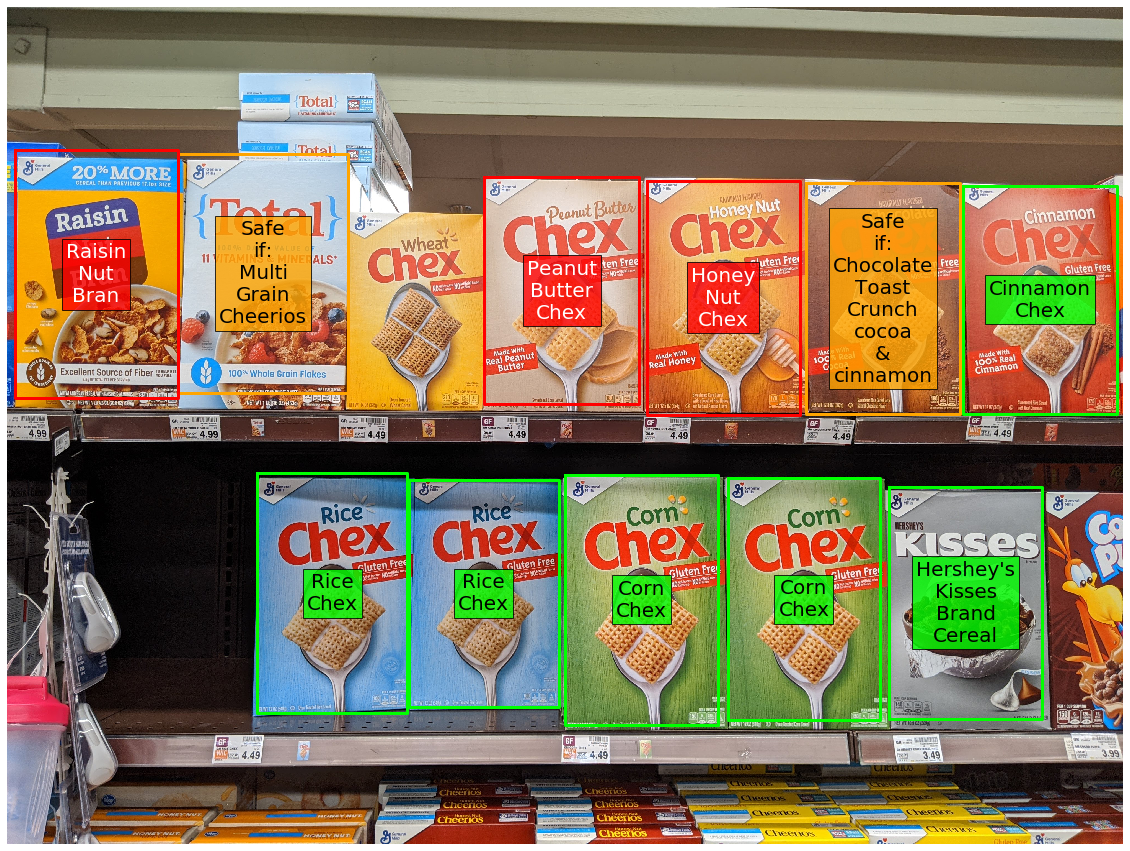

In [12]:
fig, ax = plt.subplots(1, figsize=(20,20))

ax.imshow(img)
ax.set_axis_off()

# Plot bonding boxes and annotations
for result in prediction_results:
    box = result['box']
    label = result['label']
    confidence = result['confidence']
    fontsize = (box[3]-box[1]) / img.size[1]

    # if no allergies selected, all are safe
    if len(allergies) == 0:
        symbol = copy.deepcopy(check_symbol)
        box_color.append('lime')
    else:
        # if cereal type is unknown
        if label == '':
            color = 'orange'
            symbol = '?'
            fontcolor = 'black'
        else:
            # if dangerous
            if df[df.cereal_name==label][allergies].sum().sum() > 0:
                color = 'red'
                symbol = 'X'
                fontcolor = 'white'
            else:
                # if unknown
                if df[df.cereal_name==label][allergies].isnull().values.any():
                    color = 'orange'
                    symbol = '?'
                    fontcolor = 'black'
                # if safe
                else:
                    color = 'lime'
                    symbol = u'\u2713'
                    fontcolor = 'black'

    # if not confident in cereal identification
    if confidence == 0 and label != '':
        color = 'orange'
        fontcolor = 'black'
        if df[df.cereal_name==label][allergies].sum().sum() > 0:
            label = 'Not safe if:\n' + label
        else:
            if df[df.cereal_name==label][allergies].isnull().values.any():
                label = label
            else:
                label = 'Safe if:\n' + label

    # plot boxes
    ax.plot([box[0],box[2], box[2],box[0],box[0]],
        [box[1],box[1],box[3],box[3],box[1]],
        linewidth=3, color=color)
    # plot labels
    ax.text(np.mean([box[0], box[2]]),
        np.mean([box[1],box[3]]),
        label.replace(" ", "\n"),
        fontsize=np.max([fontsize*50, 20]),
        color=fontcolor,
        bbox=dict(facecolor=color, alpha=0.8),
        horizontalalignment='center', verticalalignment='center')